## Homework 1 Solutions
### CSCI 4270 / 6270
### Due: January 19, 2024


In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

## Problem 1


In [244]:
def p1_checker(fname, m, n):
    img = cv2.imread(fname)
    if img is None:
        print('Failed to open the image')
        return -1
    else:
        #print('Successfully opened the image')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert colors to RBG 
        #print(img.shape)
        y, x, _ = img.shape
        minDim = min(y,x)
        #print("minDim", minDim)
        startY = (y-minDim)//2
        #print("startY", startY)
        startX = (x-minDim)//2
        #print("startX", startX)
        img = img[startY:startY+minDim, startX:startX+minDim, ::] #crops a square at the center
        #print("img square shape:", img.shape)
        img = cv2.resize(img, (m, m))               #normal image resized to mxm
        top_r = np.transpose(img[::-1],(1,0,2))     #rotate 90 clockwise
        bot_r = img[::-1,::-1]                      #rotate 180
        bot_l = np.transpose(img[:,::-1],(1,0,2))   #rotate 270
        fourSquare = np.empty((m*2,m*2, 3))         #creates empty matrix that can fit the four rotated squares
        fourSquare[:m,:m] = img
        fourSquare[:m,m:] = top_r
        fourSquare[m:,m:] = bot_r
        fourSquare[m:,:m] = bot_l
        fourSquare = fourSquare.astype(int)
        result = np.tile(fourSquare[:,:], (n,n,1))
        print("Final shape is {}".format(result.shape))
        plt.axis("off")
        plt.imshow(result)
        plt.show()
        

Final shape is (400, 400, 3)


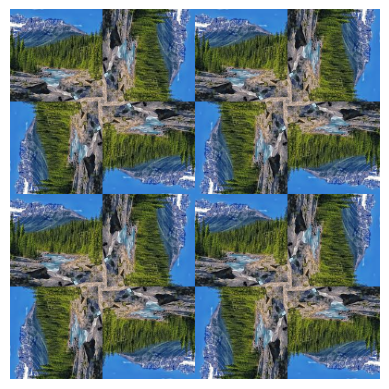

In [245]:
fn = './images/mountain.jpg'
m = 100
n = 2

p1_checker(fn, m, n)

Final shape is (1024, 1024, 3)


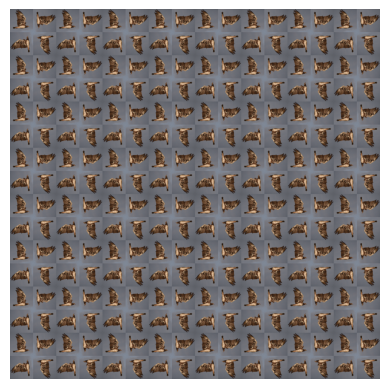

In [246]:
fn = './images/eagle.jpg'
m = 64
n = 8

p1_checker(fn, m, n)

## Problem 2



In [250]:
def p2_vignette(fn, r0, c0):
    img = cv2.imread(fn)
    if img is None:
        print('Failed to open the image')
        return -1
    else:
        print('Successfully opened the image')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert colors to RBG 
        m, n, _ = img.shape
        maxD = np.sqrt(max(r0, m-1-r0)**2 + max(c0, n-1-c0)**2)     #formula for max distance
        print("d_m =", round(maxD,1))
        #creates an array from 0 to m-1 and subtracts r0 from every entry then squares every entry
        i = (np.arange(m) - r0) ** 2
        #repeat that array n amount of times to creat mxn sized array
        i = np.tile(i,(n,1))
        #same process but for columns repeated m amount of times
        j = ((np.arange(n) - c0) ** 2)
        j = np.tile(j,(m,1)).T
        d = np.sqrt(i+j)            #adds the value from both arrays together and square roots each entry creating Dij matrix
        w = 1 - np.sqrt(d/maxD)     #create w matrix based on Dij matrix
        w = np.expand_dims(w, 2)    #give a third dimension to the 2d w matrix to interact with rgb layers
        w = np.tile(w, (1,1,3))     #copy w matrix 3 times along the third dimension
        w = np.transpose(w,(1,0,2)) #cv2 to numpy transpose
        print("W[{},{}] = {}".format(m//4, n//4, round(w[m//4,n//4, 0],2)))
        print("W[{},{}] = {}".format(m//4, 3*n//4, round(w[m//4,3*n//4, 0],2)))
        print("W[{},{}] = {}".format(3*m//4, n//4, round(w[3*m//4,n//4, 0],2)))
        print("W[{},{}] = {}".format(3*m//4, 3*n//4,round(w[3*m//4,3*n//4, 0],2)))
        img = img * w               #mulitplies img with the weights
        img = img.astype(int)
        print("I[{},{}] = {}".format(m//4, n//4, img[m//4,n//4]))
        print("I[{},{}] = {}".format(m//4, 3*n//4, img[m//4,3*n//4]))
        print("I[{},{}] = {}".format(3*m//4, n//4, img[3*m//4,n//4]))
        print("I[{},{}] = {}".format(3*m//4, 3*n//4, img[3*m//4,3*n//4]))
        plt.axis("off")
        plt.imshow(img)
        plt.show()


Successfully opened the image
d_m = 223.6
W[42,75] = 0.21
W[42,225] = 0.47
W[126,75] = 0.24
W[126,225] = 0.6
I[42,75] = [12 17 34]
I[42,225] = [32 56 79]
I[126,75] = [27 26 21]
I[126,225] = [74 81 41]


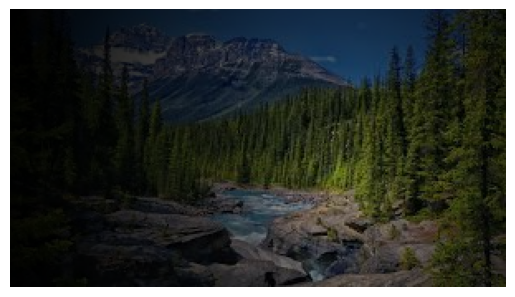

In [251]:
fn = "./images/mountain.jpg"
r0 = 100
c0 = 200

p2_vignette(fn, r0, c0)

Successfully opened the image
d_m = 335.0
W[85,128] = 0.38
W[85,384] = 0.35
W[255,128] = 0.28
W[255,384] = 0.26
I[85,128] = [86 87 88]
I[85,384] = [82 82 83]
I[255,128] = [41 39 36]
I[255,384] = [3 3 6]


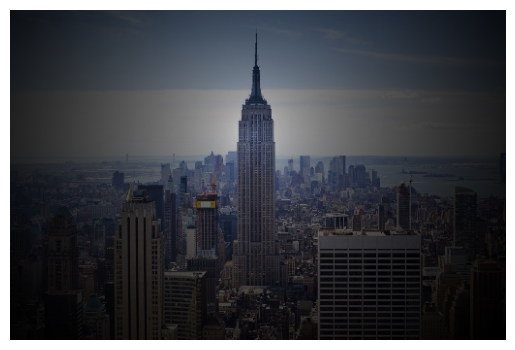

In [252]:
fn = "./images/skyline.jpg"
r0 = 130
c0 = 250

p2_vignette(fn, r0, c0)

## Problem 3


In [253]:
def p3_block(fn, m, n, b):
    im = cv2.imread(fn,0)
    M, N = im.shape
    #print(im.shape)
    sm = M/m
    sn = N/n
    downSize = np.zeros((m, n), dtype=np.float32)
    #for loop through the size of the downsized image to find the mean of the region of the original img
    for i in range(m):
        for j in range(n):
            downSize[i, j] = np.mean(im[round(i * sm):round((i + 1) * sm), round(j * sn):round((j + 1) * sn)])
    median = np.median(downSize)    #median value of the whole matrix for the threshold
    #creates a binary image by making new matrix of either value 225 or 0 depending if the downSize pixel is >= the median
    binImage = np.where(downSize >= median, 255, 0).astype(np.uint8)
    print("Downsized images are {}".format(downSize.shape))
    #creates block image by repeating the value at a pixel b times along the row and b times along the col
    blockIm = np.repeat(np.repeat(downSize, b, axis=0), b, axis=1)
    #does the same for binary images\
    blockBinIm = np.repeat(np.repeat(binImage, b, axis=0), b, axis=1)
    print("Block images are {}".format(blockIm.shape))
    print("Average intensity at ({}, {}) is {:.1f}".format(m//4, n//4, downSize[m//4,n//4]))
    print("Average intensity at ({}, {}) is {:.1f}".format(m//4, 3*n//4, downSize[m//4,3*n//4]))
    print("Average intensity at ({}, {}) is {:.1f}".format(3*m//4, n//4, downSize[3*m//4,n//4]))
    print("Average intensity at ({}, {}) is {:.1f}".format(3*m//4, 3*n//4, downSize[3*m//4,3*n//4]))
    print("Binary threshold: {:.1f}".format(median))
    downSize = np.round(downSize).astype(np.uint8)
    fig, axs = plt.subplots(2, 1, figsize=(16,12))
    axs[0].imshow(blockIm, cmap='gray')
    axs[0].axis('off')
    axs[1].imshow(blockBinIm, cmap='gray')
    axs[1].axis('off')
    plt.show()

Downsized images are (25, 18)
Block images are (375, 270)
Average intensity at (6, 4) is 59.2
Average intensity at (6, 13) is 55.5
Average intensity at (18, 4) is 158.3
Average intensity at (18, 13) is 35.3
Binary threshold: 134.7


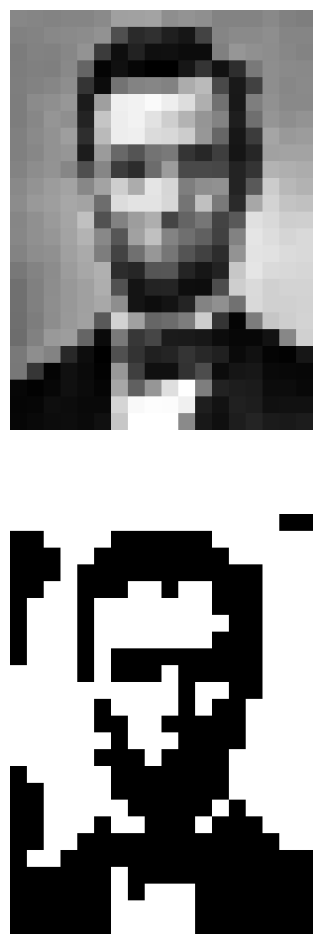

In [254]:
fname = "./images/lincoln1.jpg"
m = 25
n = 18
b = 15

p3_block(fname, m, n, b)

Downsized images are (30, 16)
Block images are (420, 224)
Average intensity at (7, 4) is 22.0
Average intensity at (7, 12) is 27.1
Average intensity at (22, 4) is 15.1
Average intensity at (22, 12) is 27.3
Binary threshold: 27.7


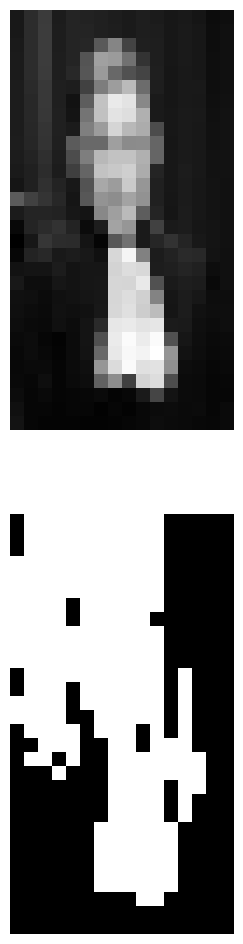

In [255]:
fname = "./images/ginsburg.jpg"
m = 30
n = 16
b = 14

p3_block(fname, m, n, b)